# Text preprocessing

In [1]:
import nltk
from pycocotools.coco import COCO
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

import os
import pickle
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn




In [2]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zhera\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
class Vocab(object):
    
    def __init__(self):
        self.w2i = {} # word to index
        self.i2w = {}
        self.index = 0
    
    # if v is a Vocab object, v(token) will return the index associated with the token
    def __call__(self,token):
        if not token in self.w2i:
            return self.w2i["<unk>"]
        return self.w2i[token]
    
    def __len__(self):
        return len(self.w2i)
    
    def add_token(self,token):
        if not token in self.w2i:
            # if the token is new, assign an index to it and update w2i, i2w, update index
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1
    
            
        

In [3]:
def build_vocabulary(json,threshold):
    coco = COCO(json) # initialize COCO object
    counter = Counter() # used to create dictionary based on text: word, freq
    ids = coco.anns.keys() # 
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]["caption"])
        tokens = nltk.tokenize.word_tokenize(caption.lower()) # kind of like split
        counter.update(tokens)
        if (i+1) % 50000 == 0:
            print(f"[{i+1}/{len(ids)}] Captions Tokenized")
        
    # if word frequence is less than threhold, discard the word
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
    
    # create vocabulary wrapper + add special tokens
    #vocab = Vocab()
    #vocab.add_token("<pad>")
    #vocab.add_token("<start>")
    #vocab.add_token("<end>")
    #vocab.add_token("<unk>")
    
    with open("vocabulary.pkl","rb") as f:
        vocab = pickle.load(f)
    
    # add words to vocab
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

In [28]:
os.listdir("../../Datasets/Image Captioning/annotations_trainval2017/annotations/")

['captions_train2017.json',
 'captions_val2017.json',
 'instances_train2017.json',
 'instances_val2017.json',
 'person_keypoints_train2017.json',
 'person_keypoints_val2017.json']

In [3]:
# build vocabulary on training set and save it 
vocab = build_vocabulary(json="../../Datasets/Image Captioning/annotations_trainval2017/annotations/captions_train2017.json",threshold=4)
vocab_path = "vocabulary.pkl"
with open(vocab_path,"wb") as f:
    pickle.dump(vocab,f)
print(f"Total vocabulary size: {len(vocab)}")


NameError: name 'build_vocabulary' is not defined

# Resize Image

In [3]:
def reshape_image(image,shape):
    return image.resize(shape,Image.ANTIALIAS)

def reshape_images(image_path, output_path, shape):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    images = os.listdir(image_path)
    num_im = len(images)
    for i, img in enumerate(images):
        with open(os.path.join(image_path, img), "r+b") as f:
            with Image.open(f) as image:
                image = reshape_image(image,shape)
                image.save(os.path.join(output_path,img),image.format)
        if (i+1) % 20000 == 0:
            print(f"[{i+1}/{num_im}] Resized and Saved")

                

### just use torch.transforms

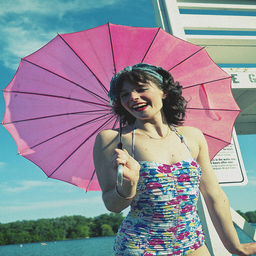

In [39]:
img = Image.open("test.jpg")
img1 = reshape_image(img,[256,256])
img1

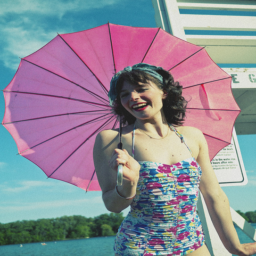

In [41]:
transform=transforms.Resize((256,256))
transform(img)

# Data Loader

In [3]:
class CustomCocoDataset(data.Dataset):
    def __init__(self,data_path,coco_json_path,vocabulary,transform=None):
        self.root = data_path # image directory
        self.coco_data = COCO(coco_json_path) # coco annotaion file path
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary # vocabulary wrapper
        self.transform = transform
        print("Total samples: ", len(self.indices))
    
    def __getitem__(self,idx):
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]["caption"]
        image_id = coco_data.anns[annotation_id]["image_id"]
        image_path = coco_data.loadImgs(image_id)[0]["file_name"]
        
        image = Image.open(os.path.join(self.root,image_path)).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        
        # convert Caption to word indices
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary("<start>"))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary("<end>"))
        target = torch.Tensor(caption)
        return image, target
    
    def __len__(self):
        return len(self.indices)
        

In [4]:
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # sort data list by caption length (descending order)
    data_batch.sort(key=lambda d:len(d[1]),reverse=True)
    img, caps = zip(*data_batch)
    
    # change batch_size number of (3, width, height) into (batch_size, 3, width, height)
    imgs = torch.stack(img,0)
    
    # combining captions together like image
    cap_lens = [len(cap) for cap in caps] # a list of caption lengths
    tgts = torch.zeros(len(caps),max(cap_lens)).long() # matrix of 0 --> (num_caption,max_caption_length)
    for i, cap in enumerate(caps):
        end = cap_lens[i] # the length of the caption
        tgts[i, :end] = cap[:end] # beginning are captions, end with padded zeros
    return imgs, tgts, cap_lens



# return dataloader
def get_loader(data_path,coco_path,vocabulary,transform,batch_size,shuffle):
    # COCO caption dataset
    coco_dataset = CustomCocoDataset(data_path,coco_path,vocabulary,transform)
    
    # Dataloader for COCO dataset
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataset,
                                                    batch_size=batch_size,
                                                    shuffle=shuffle,
                                                    collate_fn=collate_function)
    return custom_data_loader
    

In [5]:
with open("vocabulary.pkl","rb") as f:
    vocabulary = pickle.load(f)

In [6]:
transform = transforms.Compose([
                     transforms.Resize((256,256)),
                     transforms.RandomCrop(224),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor(),
                     transforms.Normalize((0.485,0.456,0.406),
                                         (0.229,0.224,0.225))])


trainloader = get_loader("../../Datasets/Image Captioning/train2017",
            "../../Datasets/Image Captioning/annotations_trainval2017/annotations/captions_train2017.json",
            vocabulary,transform,64,shuffle=True)

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
Total samples:  591753


In [7]:
valloader = get_loader("../../Datasets/Image Captioning/val2017",
            "../../Datasets/Image Captioning/annotations_trainval2017/annotations/captions_val2017.json",
            vocabulary,transform,64,shuffle=True)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Total samples:  25014


In [8]:
os.listdir("../../Datasets/Image Captioning/annotations_trainval2017/annotations")

['captions_train2017.json',
 'captions_val2017.json',
 'instances_train2017.json',
 'instances_val2017.json',
 'person_keypoints_train2017.json',
 'person_keypoints_val2017.json']

# Models

In [9]:
class CNN(nn.Module):
    def __init__(self,embedding_size,weight_path):
        # pretrained ResNext-50
        super(CNN,self).__init__()
        resnet = models.resnext101_32x8d(pretrained=False)
        resnet.load_state_dict(torch.load(weight_path))
        # exclude the last layer
        module_list = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*module_list) 
        self.linear = nn.Linear(resnet.fc.in_features,embedding_size) # embed the output features
        self.batch_norm = nn.BatchNorm1d(embedding_size,momentum=0.01)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self,input_imgs):
        # extract features
        with torch.no_grad():
            features = self.resnet(input_imgs)
        
        # embed the features
        features = features.reshape(features.size(0),-1)
        features = self.dropout(self.batch_norm(self.linear(features)))
        return features


        
        

In [10]:
class LSTM(nn.Module):
    def __init__(self,embed,hidden,vocab,num_layers,max_seq_len=30):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(vocab,embed)
        #self.lstm = nn.LSTM(embed,hidden,num_layers,batch_first=True,dropout=0.1)
        self.lstm = nn.LSTM(embed*2,hidden,num_layers,batch_first=True,dropout=0.1)
        self.linear = nn.Linear(hidden,vocab)
        self.max_seq_len = max_seq_len
    
    def forward(self,input_features,capts,lens):
        # decode image feature vectors and generate captions
        ####
        capts = capts[:,:-1] # for each caption, ignore the last token
        ###
        
        embeddings = self.embedding(capts)
        # input_features (batch,embed_size)
        # embeddings (batch,sequence_len,embed_size)
        
        #####
        repeated_features = input_features.unsqueeze(1).repeat(1,embeddings.size(dim=1),1)
        embeddings = torch.cat((repeated_features,embeddings),2)
        
        #####
        
        #embeddings = torch.cat((input_features.unsqueeze(1),embeddings), 1)
        #lstm_input = pack_padded_sequence(embeddings, np.array(lens), batch_first=True)
        
        lstm_input = pack_padded_sequence(embeddings, np.array(lens)-1, batch_first=True)
        hidden_variables,_ = self.lstm(lstm_input)
        model_outputs = self.linear(hidden_variables[0])
        return model_outputs
    
    def sample(self,input_features,lstm_states=None):
        # generate captions for given image features
        
        sampled_indices = []
        features = input_features
        
        ### 
        word = "<start>"
        embedding = self.embedding(vocabulary(word))
        lstm_inputs = torch.cat((features,embedding)).unsequeeze(1)
        
        ###
        
        for i in range(self.max_seq_len):
            # hidden_variables (batch, 1, hidden_size)
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs,lstm_states)
            # output (batch,num_vocab)
            model_outputs = self.linear(hidden_variables.squeeze(1))
            # predicted outputs (batch,)
            _, predicted_outputs = model_outputs.max(1)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding(predicted_outputs)
            lstm_inputs =torch.cat((features,embedding)).unsequeeze(1)
        # sampled_ids (batch,max_seq_len)
        sampled_indices = torch.stack(sampled_indices,1)
        return sampled_indices

In [11]:
a = torch.randn((5,3))
b = torch.randn((3))
c=torch.cat((b.unsqueeze(0),a),0)
c.shape
print("a", a)
print("b",b)
print("c",c)

a tensor([[ 1.9885, -0.2967, -0.6772],
        [ 0.1102, -0.6101,  0.4576],
        [-1.3866, -1.3573, -0.4582],
        [ 0.0798, -2.0515,  1.0359],
        [-1.3850,  0.9090, -1.3585]])
b tensor([ 0.2892, -1.8891, -0.4849])
c tensor([[ 0.2892, -1.8891, -0.4849],
        [ 1.9885, -0.2967, -0.6772],
        [ 0.1102, -0.6101,  0.4576],
        [-1.3866, -1.3573, -0.4582],
        [ 0.0798, -2.0515,  1.0359],
        [-1.3850,  0.9090, -1.3585]])


what if we concatenate the feature to each element in input sequence, so the feature information of the picture is always available throughtout

# Training & validation routine

In [11]:
def validate(encoder, decoder, lossfn, valdataloader,device):
    encoder.eval()
    decoder.eval()
    steps = len(valdataloader)
    val_loss = 0
    
    with torch.no_grad():
        for batch in valdataloader:
            img, caps, lens = batch
            img, caps = img.to(device), caps.to(device)
            #target = pack_padded_sequence(caps,np.array(lens),batch_first=True)[0]
            target = pack_padded_sequence(caps[:,1:],np.array(lens)-1,batch_first=True)[0]
            
            features = encoder(img)
            output = decoder(features,caps,lens)
            loss = lossfn(output,target)
            val_loss += loss.item()
    print(f"Validation loss is {val_loss/steps:.6f}")
    return val_loss/steps

In [13]:
from tqdm.auto import tqdm
def train(encoder,decoder,lossfn,optimizer,traindataloader,valdataloader,ep,print_freq,device,run):
    step = 0
    total_steps = ep * len(traindataloader)
    print_every = total_steps // print_freq
    progress = tqdm(range(total_steps))
    best_val = 1000
    list_trainloss = []
    list_valloss = []
    current_trainloss = 0
    current_valloss = 0
    
    for i in np.arange(ep):
        for batch in traindataloader:
            encoder.train()
            decoder.train()
            step += 1
            imgs, caps, lens = batch
            imgs, caps = imgs.to(device), caps.to(device)
            #targets = pack_padded_sequence(caps, np.array(lens), batch_first=True)[0]
            targets = pack_padded_sequence(caps[:,1:], np.array(lens)-1, batch_first=True)[0]
            
            # froward pass
            encoder.zero_grad()
            decoder.zero_grad()
            
            features = encoder(imgs)
            outputs = decoder(features,caps,lens)
            print("outputs: ",outputs)
            loss = lossfn(outputs,targets)
            print("targets: ",targets)
            current_trainloss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(decoder.parameters(),1)
            torch.nn.utils.clip_grad_norm_(encoder.parameters(),1)
            optimizer.step()
            
            progress.update(1)
            
            # print
            if step % print_every == 0:
                loss = current_trainloss / print_every
                list_trainloss.append(loss)
                print(f"Epoch: {i+1}/{ep}  Training loss: {loss:.6f}")
                current_trainloss = 0
                
                current_valloss = validate(encoder, decoder, lossfn, valdataloader,device)
                list_valloss.append(current_valloss)
                if current_valloss < best_val:
                    best_val = current_valloss
                    torch.save(encoder.state_dict(),"Weights/complex_run-"+str(run)+"-encoder.pth")
                    torch.save(decoder.state_dict(),"Weights/complex_run-"+str(run)+"-decoder.pth")
        torch.save(optimizer.state_dict(),"Weights/complex-optimizer.pth")
        #np.save("Loss/complex_run_"+str(run)+"_trainloss.npy",np.array(list_trainloss))
        #np.save("Loss/complex_run_"+str(run)+"_valloss.npy",np.array(list_valloss))

        

# Train  - 2.6568
dropout = .05, gradient clip not helping

In [15]:
weight_path="../../Pretrained_Weights/resnext50_32x4d-7cdf4587.pth"
encoder = CNN(256,weight_path).cuda()
decoder = LSTM(256,512,len(vocabulary),1).cuda()

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "layer3.6.conv1.weight", "layer3.6.bn1.weight", "layer3.6.bn1.bias", "layer3.6.bn1.running_mean", "layer3.6.bn1.running_var", "layer3.6.conv2.weight", "layer3.6.bn2.weight", "layer3.6.bn2.bias", "layer3.6.bn2.running_mean", "layer3.6.bn2.running_var", "layer3.6.conv3.weight", "layer3.6.bn3.weight", "layer3.6.bn3.bias", "layer3.6.bn3.running_mean", "layer3.6.bn3.running_var", "layer3.7.conv1.weight", "layer3.7.bn1.weight", "layer3.7.bn1.bias", "layer3.7.bn1.running_mean", "layer3.7.bn1.running_var", "layer3.7.conv2.weight", "layer3.7.bn2.weight", "layer3.7.bn2.bias", "layer3.7.bn2.running_mean", "layer3.7.bn2.running_var", "layer3.7.conv3.weight", "layer3.7.bn3.weight", "layer3.7.bn3.bias", "layer3.7.bn3.running_mean", "layer3.7.bn3.running_var", "layer3.8.conv1.weight", "layer3.8.bn1.weight", "layer3.8.bn1.bias", "layer3.8.bn1.running_mean", "layer3.8.bn1.running_var", "layer3.8.conv2.weight", "layer3.8.bn2.weight", "layer3.8.bn2.bias", "layer3.8.bn2.running_mean", "layer3.8.bn2.running_var", "layer3.8.conv3.weight", "layer3.8.bn3.weight", "layer3.8.bn3.bias", "layer3.8.bn3.running_mean", "layer3.8.bn3.running_var", "layer3.9.conv1.weight", "layer3.9.bn1.weight", "layer3.9.bn1.bias", "layer3.9.bn1.running_mean", "layer3.9.bn1.running_var", "layer3.9.conv2.weight", "layer3.9.bn2.weight", "layer3.9.bn2.bias", "layer3.9.bn2.running_mean", "layer3.9.bn2.running_var", "layer3.9.conv3.weight", "layer3.9.bn3.weight", "layer3.9.bn3.bias", "layer3.9.bn3.running_mean", "layer3.9.bn3.running_var", "layer3.10.conv1.weight", "layer3.10.bn1.weight", "layer3.10.bn1.bias", "layer3.10.bn1.running_mean", "layer3.10.bn1.running_var", "layer3.10.conv2.weight", "layer3.10.bn2.weight", "layer3.10.bn2.bias", "layer3.10.bn2.running_mean", "layer3.10.bn2.running_var", "layer3.10.conv3.weight", "layer3.10.bn3.weight", "layer3.10.bn3.bias", "layer3.10.bn3.running_mean", "layer3.10.bn3.running_var", "layer3.11.conv1.weight", "layer3.11.bn1.weight", "layer3.11.bn1.bias", "layer3.11.bn1.running_mean", "layer3.11.bn1.running_var", "layer3.11.conv2.weight", "layer3.11.bn2.weight", "layer3.11.bn2.bias", "layer3.11.bn2.running_mean", "layer3.11.bn2.running_var", "layer3.11.conv3.weight", "layer3.11.bn3.weight", "layer3.11.bn3.bias", "layer3.11.bn3.running_mean", "layer3.11.bn3.running_var", "layer3.12.conv1.weight", "layer3.12.bn1.weight", "layer3.12.bn1.bias", "layer3.12.bn1.running_mean", "layer3.12.bn1.running_var", "layer3.12.conv2.weight", "layer3.12.bn2.weight", "layer3.12.bn2.bias", "layer3.12.bn2.running_mean", "layer3.12.bn2.running_var", "layer3.12.conv3.weight", "layer3.12.bn3.weight", "layer3.12.bn3.bias", "layer3.12.bn3.running_mean", "layer3.12.bn3.running_var", "layer3.13.conv1.weight", "layer3.13.bn1.weight", "layer3.13.bn1.bias", "layer3.13.bn1.running_mean", "layer3.13.bn1.running_var", "layer3.13.conv2.weight", "layer3.13.bn2.weight", "layer3.13.bn2.bias", "layer3.13.bn2.running_mean", "layer3.13.bn2.running_var", "layer3.13.conv3.weight", "layer3.13.bn3.weight", "layer3.13.bn3.bias", "layer3.13.bn3.running_mean", "layer3.13.bn3.running_var", "layer3.14.conv1.weight", "layer3.14.bn1.weight", "layer3.14.bn1.bias", "layer3.14.bn1.running_mean", "layer3.14.bn1.running_var", "layer3.14.conv2.weight", "layer3.14.bn2.weight", "layer3.14.bn2.bias", "layer3.14.bn2.running_mean", "layer3.14.bn2.running_var", "layer3.14.conv3.weight", "layer3.14.bn3.weight", "layer3.14.bn3.bias", "layer3.14.bn3.running_mean", "layer3.14.bn3.running_var", "layer3.15.conv1.weight", "layer3.15.bn1.weight", "layer3.15.bn1.bias", "layer3.15.bn1.running_mean", "layer3.15.bn1.running_var", "layer3.15.conv2.weight", "layer3.15.bn2.weight", "layer3.15.bn2.bias", "layer3.15.bn2.running_mean", "layer3.15.bn2.running_var", "layer3.15.conv3.weight", "layer3.15.bn3.weight", "layer3.15.bn3.bias", "layer3.15.bn3.running_mean", "layer3.15.bn3.running_var", "layer3.16.conv1.weight", "layer3.16.bn1.weight", "layer3.16.bn1.bias", "layer3.16.bn1.running_mean", "layer3.16.bn1.running_var", "layer3.16.conv2.weight", "layer3.16.bn2.weight", "layer3.16.bn2.bias", "layer3.16.bn2.running_mean", "layer3.16.bn2.running_var", "layer3.16.conv3.weight", "layer3.16.bn3.weight", "layer3.16.bn3.bias", "layer3.16.bn3.running_mean", "layer3.16.bn3.running_var", "layer3.17.conv1.weight", "layer3.17.bn1.weight", "layer3.17.bn1.bias", "layer3.17.bn1.running_mean", "layer3.17.bn1.running_var", "layer3.17.conv2.weight", "layer3.17.bn2.weight", "layer3.17.bn2.bias", "layer3.17.bn2.running_mean", "layer3.17.bn2.running_var", "layer3.17.conv3.weight", "layer3.17.bn3.weight", "layer3.17.bn3.bias", "layer3.17.bn3.running_mean", "layer3.17.bn3.running_var", "layer3.18.conv1.weight", "layer3.18.bn1.weight", "layer3.18.bn1.bias", "layer3.18.bn1.running_mean", "layer3.18.bn1.running_var", "layer3.18.conv2.weight", "layer3.18.bn2.weight", "layer3.18.bn2.bias", "layer3.18.bn2.running_mean", "layer3.18.bn2.running_var", "layer3.18.conv3.weight", "layer3.18.bn3.weight", "layer3.18.bn3.bias", "layer3.18.bn3.running_mean", "layer3.18.bn3.running_var", "layer3.19.conv1.weight", "layer3.19.bn1.weight", "layer3.19.bn1.bias", "layer3.19.bn1.running_mean", "layer3.19.bn1.running_var", "layer3.19.conv2.weight", "layer3.19.bn2.weight", "layer3.19.bn2.bias", "layer3.19.bn2.running_mean", "layer3.19.bn2.running_var", "layer3.19.conv3.weight", "layer3.19.bn3.weight", "layer3.19.bn3.bias", "layer3.19.bn3.running_mean", "layer3.19.bn3.running_var", "layer3.20.conv1.weight", "layer3.20.bn1.weight", "layer3.20.bn1.bias", "layer3.20.bn1.running_mean", "layer3.20.bn1.running_var", "layer3.20.conv2.weight", "layer3.20.bn2.weight", "layer3.20.bn2.bias", "layer3.20.bn2.running_mean", "layer3.20.bn2.running_var", "layer3.20.conv3.weight", "layer3.20.bn3.weight", "layer3.20.bn3.bias", "layer3.20.bn3.running_mean", "layer3.20.bn3.running_var", "layer3.21.conv1.weight", "layer3.21.bn1.weight", "layer3.21.bn1.bias", "layer3.21.bn1.running_mean", "layer3.21.bn1.running_var", "layer3.21.conv2.weight", "layer3.21.bn2.weight", "layer3.21.bn2.bias", "layer3.21.bn2.running_mean", "layer3.21.bn2.running_var", "layer3.21.conv3.weight", "layer3.21.bn3.weight", "layer3.21.bn3.bias", "layer3.21.bn3.running_mean", "layer3.21.bn3.running_var", "layer3.22.conv1.weight", "layer3.22.bn1.weight", "layer3.22.bn1.bias", "layer3.22.bn1.running_mean", "layer3.22.bn1.running_var", "layer3.22.conv2.weight", "layer3.22.bn2.weight", "layer3.22.bn2.bias", "layer3.22.bn2.running_mean", "layer3.22.bn2.running_var", "layer3.22.conv3.weight", "layer3.22.bn3.weight", "layer3.22.bn3.bias", "layer3.22.bn3.running_mean", "layer3.22.bn3.running_var". 
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([128, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 64, 1, 1]).
	size mismatch for layer1.0.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.0.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.0.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.0.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.0.conv2.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 8, 3, 3]).
	size mismatch for layer1.0.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.0.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.0.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.0.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.0.conv3.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for layer1.1.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.1.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.1.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.1.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.1.conv2.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 8, 3, 3]).
	size mismatch for layer1.1.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.1.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.1.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.1.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.1.conv3.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for layer1.2.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for layer1.2.bn1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.2.bn1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.2.bn1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.2.bn1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.2.conv2.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 8, 3, 3]).
	size mismatch for layer1.2.bn2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.2.bn2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.2.bn2.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.2.bn2.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer1.2.conv3.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([256, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for layer2.0.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.conv2.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for layer2.0.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.conv3.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for layer2.1.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.conv2.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for layer2.1.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.conv3.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for layer2.2.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for layer2.2.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.2.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.2.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.2.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.2.conv2.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for layer2.2.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.2.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.2.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.2.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.2.conv3.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for layer2.3.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for layer2.3.bn1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.3.bn1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.3.bn1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.3.bn1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.3.conv2.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 16, 3, 3]).
	size mismatch for layer2.3.bn2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.3.bn2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.3.bn2.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.3.bn2.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.3.conv3.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1, 1]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([512, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 512, 1, 1]).
	size mismatch for layer3.0.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.conv2.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for layer3.0.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.conv3.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.1.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.conv2.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for layer3.1.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.conv3.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.2.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.2.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.2.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.2.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.2.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.2.conv2.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for layer3.2.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.2.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.2.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.2.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.2.conv3.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.3.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.3.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.3.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.3.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.3.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.3.conv2.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for layer3.3.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.3.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.3.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.3.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.3.conv3.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.4.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.4.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.4.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.4.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.4.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.4.conv2.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for layer3.4.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.4.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.4.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.4.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.4.conv3.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.5.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer3.5.bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.5.bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.5.bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.5.bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.5.conv2.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 32, 3, 3]).
	size mismatch for layer3.5.bn2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.5.bn2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.5.bn2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.5.bn2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.5.conv3.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 1, 1]).
	size mismatch for layer4.0.conv1.weight: copying a param with shape torch.Size([1024, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for layer4.0.bn1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.bn1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.bn1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.bn1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.conv2.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 64, 3, 3]).
	size mismatch for layer4.0.bn2.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.bn2.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.bn2.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.bn2.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.conv3.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).
	size mismatch for layer4.1.conv1.weight: copying a param with shape torch.Size([1024, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).
	size mismatch for layer4.1.bn1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.bn1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.bn1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.bn1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.conv2.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 64, 3, 3]).
	size mismatch for layer4.1.bn2.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.bn2.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.bn2.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.bn2.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.conv3.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).
	size mismatch for layer4.2.conv1.weight: copying a param with shape torch.Size([1024, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).
	size mismatch for layer4.2.bn1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.2.bn1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.2.bn1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.2.bn1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.2.conv2.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([2048, 64, 3, 3]).
	size mismatch for layer4.2.bn2.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.2.bn2.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.2.bn2.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.2.bn2.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.2.conv3.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 2048, 1, 1]).

In [15]:
lossfn = nn.CrossEntropyLoss()
parameters = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(parameters,lr=5e-5)

In [16]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",1)

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 5.838681
Validation loss is 4.670101
Epoch: 1/2  Training loss: 4.306256
Validation loss is 4.074023
Epoch: 1/2  Training loss: 3.925966
Validation loss is 3.802996
Epoch: 1/2  Training loss: 3.714370
Validation loss is 3.624987
Epoch: 1/2  Training loss: 3.562796
Validation loss is 3.489671
Epoch: 1/2  Training loss: 3.437919
Validation loss is 3.377785
Epoch: 1/2  Training loss: 3.339666
Validation loss is 3.279808
Epoch: 1/2  Training loss: 3.246742
Validation loss is 3.195478
Epoch: 1/2  Training loss: 3.167097
Validation loss is 3.121077
Epoch: 1/2  Training loss: 3.103836
Validation loss is 3.053070
Epoch: 2/2  Training loss: 3.030107
Validation loss is 2.993224
Epoch: 2/2  Training loss: 2.968823
Validation loss is 2.939629
Epoch: 2/2  Training loss: 2.919708
Validation loss is 2.888420
Epoch: 2/2  Training loss: 2.878151
Validation loss is 2.844901
Epoch: 2/2  Training loss: 2.829329
Validation loss is 2.803998
Epoch: 2/2  Training loss: 2.787226
Vali

In [17]:
np.save("Loss/run1_trainloss.npy",np.array(train_loss))
np.save("Loss/run1_valloss.npy",np.array(val_loss))

In [16]:
encoder.load_state_dict(torch.load("Weights/run-1-encoder.pth"))
decoder.load_state_dict(torch.load("Weights/run-1-decoder.pth"))

<All keys matched successfully>

### learning rate too high? - 1e-6

In [19]:
optimizer = torch.optim.Adam(parameters,lr=1e-6)

In [20]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",2)

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 2.653892
Validation loss is 2.657106
Epoch: 1/2  Training loss: 2.648918
Validation loss is 2.657422
Epoch: 1/2  Training loss: 2.650749
Validation loss is 2.657517
Epoch: 1/2  Training loss: 2.659109
Validation loss is 2.657288
Epoch: 1/2  Training loss: 2.647917
Validation loss is 2.657278


KeyboardInterrupt: 

### 1e-7

In [16]:
optimizer = torch.optim.Adam(parameters,lr=1e-7)

In [17]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",2)

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 2.663708
Validation loss is 2.657460
Epoch: 1/2  Training loss: 2.654942
Validation loss is 2.657063
Epoch: 1/2  Training loss: 2.648246
Validation loss is 2.656090


KeyboardInterrupt: 

### 1e-8

In [18]:
optimizer = torch.optim.Adam(parameters,lr=1e-8)

In [19]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",2)

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 2.652921
Validation loss is 2.656212
Epoch: 1/2  Training loss: 2.646626
Validation loss is 2.656203
Epoch: 1/2  Training loss: 2.655619
Validation loss is 2.656042
Epoch: 1/2  Training loss: 2.654670
Validation loss is 2.656319
Epoch: 1/2  Training loss: 2.654699
Validation loss is 2.656233
Epoch: 1/2  Training loss: 2.652793
Validation loss is 2.656536
Epoch: 1/2  Training loss: 2.649031
Validation loss is 2.656218
Epoch: 1/2  Training loss: 2.648155
Validation loss is 2.656544
Epoch: 1/2  Training loss: 2.648014


KeyboardInterrupt: 

### 1e-9

In [17]:
optimizer = torch.optim.Adam(parameters,lr=1e-9)

In [18]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",2)

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 2.648475
Validation loss is 2.657818
Epoch: 1/2  Training loss: 2.651914
Validation loss is 2.657205
Epoch: 1/2  Training loss: 2.653051
Validation loss is 2.657283
Epoch: 1/2  Training loss: 2.648061
Validation loss is 2.656901


KeyboardInterrupt: 

# train with modified concatenation - 2.480
dropout = 0.1
with gradient clip = 1

In [13]:
weight_path="../../Pretrained_Weights/resnext50_32x4d-7cdf4587.pth"
encoder = CNN(256,weight_path).cuda()
decoder = LSTM(256,512,len(vocabulary),1).cuda()

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
lossfn = nn.CrossEntropyLoss()
parameters = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(parameters,lr=5e-5)

In [18]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",1)

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 4.296786
Validation loss is 4.064584
Epoch: 1/2  Training loss: 3.919571
Validation loss is 3.765735
Epoch: 1/2  Training loss: 3.675732
Validation loss is 3.562125
Epoch: 1/2  Training loss: 3.498167
Validation loss is 3.415320
Epoch: 1/2  Training loss: 3.374274
Validation loss is 3.305254
Epoch: 1/2  Training loss: 3.275870
Validation loss is 3.216977
Epoch: 1/2  Training loss: 3.190747
Validation loss is 3.146752
Epoch: 1/2  Training loss: 3.130082
Validation loss is 3.087288
Epoch: 1/2  Training loss: 3.067509
Validation loss is 3.037365
Epoch: 1/2  Training loss: 3.030340
Validation loss is 2.995509
Epoch: 2/2  Training loss: 2.972576
Validation loss is 2.954845
Epoch: 2/2  Training loss: 2.932330
Validation loss is 2.921463
Epoch: 2/2  Training loss: 2.912772
Validation loss is 2.891288
Epoch: 2/2  Training loss: 2.883407
Validation loss is 2.864756
Epoch: 2/2  Training loss: 2.852478
Validation loss is 2.839345
Epoch: 2/2  Training loss: 2.832636
Vali

In [19]:
np.save("Loss/diff_cat_run1_trainloss.npy",np.array(train_loss))
np.save("Loss/diff_cat_run1_valloss.npy",np.array(val_loss))

In [20]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,1,10,"cuda",2)

  0%|          | 0/4624 [00:00<?, ?it/s]

Epoch: 1/1  Training loss: 2.716250
Validation loss is 2.726304
Epoch: 1/1  Training loss: 2.712718
Validation loss is 2.712160
Epoch: 1/1  Training loss: 2.694764
Validation loss is 2.697652
Epoch: 1/1  Training loss: 2.681366
Validation loss is 2.685507
Epoch: 1/1  Training loss: 2.669649
Validation loss is 2.671891
Epoch: 1/1  Training loss: 2.659751
Validation loss is 2.660559
Epoch: 1/1  Training loss: 2.648188
Validation loss is 2.650131
Epoch: 1/1  Training loss: 2.633605
Validation loss is 2.639826
Epoch: 1/1  Training loss: 2.618762
Validation loss is 2.629010
Epoch: 1/1  Training loss: 2.625351
Validation loss is 2.620172


In [21]:
np.save("Loss/diff_cat_run2_trainloss.npy",np.array(train_loss))
np.save("Loss/diff_cat_run2_valloss.npy",np.array(val_loss))

In [22]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",3)

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 2.587988
Validation loss is 2.610687
Epoch: 1/2  Training loss: 2.583088
Validation loss is 2.602661
Epoch: 1/2  Training loss: 2.577594
Validation loss is 2.592141
Epoch: 1/2  Training loss: 2.569231
Validation loss is 2.584389
Epoch: 1/2  Training loss: 2.565463
Validation loss is 2.577128
Epoch: 1/2  Training loss: 2.556839
Validation loss is 2.569955
Epoch: 1/2  Training loss: 2.545301
Validation loss is 2.562106
Epoch: 1/2  Training loss: 2.543436
Validation loss is 2.554805
Epoch: 1/2  Training loss: 2.535465
Validation loss is 2.547832
Epoch: 1/2  Training loss: 2.527594
Validation loss is 2.543802
Epoch: 2/2  Training loss: 2.503344
Validation loss is 2.536677
Epoch: 2/2  Training loss: 2.499385
Validation loss is 2.530095
Epoch: 2/2  Training loss: 2.498703
Validation loss is 2.524868
Epoch: 2/2  Training loss: 2.496436
Validation loss is 2.519435
Epoch: 2/2  Training loss: 2.485118
Validation loss is 2.513169
Epoch: 2/2  Training loss: 2.477573
Vali

In [23]:
np.save("Loss/diff_cat_run3_trainloss.npy",np.array(train_loss))
np.save("Loss/diff_cat_run3_valloss.npy",np.array(val_loss))

# Only train the decoder

In [14]:
weight_path="../../Pretrained_Weights/resnext50_32x4d-7cdf4587.pth"
encoder = CNN(256,weight_path).cuda()
decoder = LSTM(256,512,len(vocabulary),1).cuda()

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [20]:
decoder.load_state_dict(torch.load("Weights/only_decoder_run-1-decoder.pth"))
encoder.load_state_dict(torch.load("Weights/only_decoder_run-1-encoder.pth"))

<All keys matched successfully>

In [15]:
lossfn = nn.CrossEntropyLoss()
parameters = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=5e-5)

In [21]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",1)
np.save("Loss/only_decoder_run1_trainloss.npy",np.array(train_loss))
np.save("Loss/only_decoder_run1_valloss.npy",np.array(val_loss))

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 5.827550
Validation loss is 4.553769
Epoch: 1/2  Training loss: 4.289462
Validation loss is 4.053737
Epoch: 1/2  Training loss: 3.898795
Validation loss is 3.754220
Epoch: 1/2  Training loss: 3.666056
Validation loss is 3.552507
Epoch: 1/2  Training loss: 3.483044
Validation loss is 3.409253
Epoch: 1/2  Training loss: 3.363534
Validation loss is 3.298647
Epoch: 1/2  Training loss: 3.272287
Validation loss is 3.212924
Epoch: 1/2  Training loss: 3.186565
Validation loss is 3.143302
Epoch: 1/2  Training loss: 3.122321
Validation loss is 3.081014
Epoch: 1/2  Training loss: 3.078768
Validation loss is 3.031479
Epoch: 2/2  Training loss: 3.009774
Validation loss is 2.990558
Epoch: 2/2  Training loss: 2.967241
Validation loss is 2.953156
Epoch: 2/2  Training loss: 2.934688
Validation loss is 2.919463
Epoch: 2/2  Training loss: 2.907811
Validation loss is 2.889125
Epoch: 2/2  Training loss: 2.879383
Validation loss is 2.861512
Epoch: 2/2  Training loss: 2.854903
Vali

In [24]:
optimizer = torch.optim.Adam(parameters, lr=5e-7)


In [25]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,2,20,"cuda",2)
np.save("Loss/only_decoder_run2_trainloss.npy",np.array(train_loss))
np.save("Loss/only_decoder_run2_valloss.npy",np.array(val_loss))

  0%|          | 0/9248 [00:00<?, ?it/s]

Epoch: 1/2  Training loss: 2.743776
Validation loss is 2.753232
Epoch: 1/2  Training loss: 2.744716
Validation loss is 2.753499


KeyboardInterrupt: 

### from beginning - continuous training

In [16]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,5,50,"cuda",1)
np.save("Loss/only_decoder2_run1_trainloss.npy",np.array(train_loss))
np.save("Loss/only_decoder2_run1_valloss.npy",np.array(val_loss))

  0%|          | 0/23120 [00:00<?, ?it/s]

Epoch: 1/5  Training loss: 5.778625
Validation loss is 4.543424
Epoch: 1/5  Training loss: 4.283694
Validation loss is 4.038916
Epoch: 1/5  Training loss: 3.891571
Validation loss is 3.739233
Epoch: 1/5  Training loss: 3.646645
Validation loss is 3.542291
Epoch: 1/5  Training loss: 3.481634
Validation loss is 3.399624
Epoch: 1/5  Training loss: 3.367926
Validation loss is 3.292597
Epoch: 1/5  Training loss: 3.263734
Validation loss is 3.207791
Epoch: 1/5  Training loss: 3.185311
Validation loss is 3.138951
Epoch: 1/5  Training loss: 3.128354
Validation loss is 3.081194
Epoch: 1/5  Training loss: 3.066580
Validation loss is 3.033211
Epoch: 2/5  Training loss: 3.018345
Validation loss is 2.988738
Epoch: 2/5  Training loss: 2.976272
Validation loss is 2.955075
Epoch: 2/5  Training loss: 2.938498
Validation loss is 2.919575
Epoch: 2/5  Training loss: 2.908890
Validation loss is 2.890168
Epoch: 2/5  Training loss: 2.881651
Validation loss is 2.864315
Epoch: 2/5  Training loss: 2.857203
Vali

In [20]:
for param_group in optimizer.param_groups:
    print(param_group)

{'params': [Parameter containing:
tensor([[-0.2760,  1.7093,  0.1519,  ..., -0.6858,  0.0695, -1.6377],
        [-0.9455, -1.0315, -1.6329,  ...,  1.9788,  0.8199, -0.8634],
        [ 0.6393, -0.6073, -2.1890,  ..., -0.7094, -0.5513,  0.5295],
        ...,
        [-2.0581,  0.3077,  0.0764,  ...,  0.3036,  0.5792, -0.7063],
        [ 1.1946,  1.9224, -0.8842,  ..., -0.3283, -0.7980, -0.7850],
        [ 0.9034,  0.4666,  1.3741,  ..., -0.4817, -0.4918,  0.3770]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.0160,  0.0527, -0.0037,  ...,  0.0237, -0.0539, -0.0073],
        [-0.0731, -0.0137,  0.0323,  ...,  0.0424,  0.0710, -0.1208],
        [ 0.0358,  0.0184,  0.0186,  ...,  0.0368,  0.0428, -0.1162],
        ...,
        [-0.0480,  0.0046,  0.0355,  ..., -0.0149, -0.0231, -0.0484],
        [ 0.0586, -0.1023, -0.0215,  ...,  0.0703, -0.0151, -0.0703],
        [ 0.0520,  0.0588, -0.0265,  ..., -0.0011, -0.0709,  0.0074]],
       device='cuda:0', require

In [17]:
torch.save(optimizer.state_dict(),"Weights/only_decoder2-optimizer.pth")

# Complex model

In [18]:
weight_path="../../Pretrained_Weights/resnext101_32x8d-8ba56ff5.pth"
encoder = CNN(256,weight_path).cuda()
decoder = LSTM(256,1024,len(vocabulary),1).cuda()

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [20]:
lossfn = nn.CrossEntropyLoss()
parameters = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(parameters,lr=5e-5)

In [17]:
for param in encoder.resnet.parameters():
    param.requires_grad=False


print(encoder)

CNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [35]:
for param in encoder.batch_norm.parameters():
    print(param)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

In [18]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,1,10,"cuda",1)
np.save("Loss/complex_run1_trainloss.npy",np.array(train_loss))
np.save("Loss/complex_run1_valloss.npy",np.array(val_loss))

  0%|          | 0/4624 [00:00<?, ?it/s]

Epoch: 1/1  Training loss: 5.210956
Validation loss is 4.126491
Epoch: 1/1  Training loss: 3.869886
Validation loss is 3.649083
Epoch: 1/1  Training loss: 3.517180
Validation loss is 3.390519
Epoch: 1/1  Training loss: 3.310704
Validation loss is 3.227240
Epoch: 1/1  Training loss: 3.184509
Validation loss is 3.114222
Epoch: 1/1  Training loss: 3.081705
Validation loss is 3.028120
Epoch: 1/1  Training loss: 3.008194
Validation loss is 2.962407
Epoch: 1/1  Training loss: 2.943775
Validation loss is 2.905173
Epoch: 1/1  Training loss: 2.890012
Validation loss is 2.859808
Epoch: 1/1  Training loss: 2.846336
Validation loss is 2.818754


In [19]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)

### decrease batch size to 64

In [15]:
for param in encoder.resnet.parameters():
    print(param)


Parameter containing:
tensor([[[[-8.0291e-04,  1.8063e-02,  1.1152e-02,  ..., -4.0384e-02,
           -7.3225e-03,  8.3619e-04],
          [-2.2159e-02, -5.8051e-02, -2.1772e-02,  ...,  1.4355e-01,
            4.6373e-02, -1.4249e-02],
          [ 1.6761e-02,  1.7584e-02, -9.3876e-02,  ..., -3.9069e-01,
           -1.8095e-01, -4.6398e-03],
          ...,
          [-1.6762e-02, -3.8921e-02, -1.7462e-01,  ..., -1.6277e-01,
            4.3646e-02,  8.8467e-02],
          [-2.7057e-02, -5.2609e-02, -1.5818e-02,  ..., -1.5119e-01,
           -2.0956e-01, -1.2613e-01],
          [ 1.6383e-02,  3.3771e-02,  2.7169e-02,  ...,  1.0462e-01,
            8.4836e-02,  3.4639e-02]],

         [[ 1.3620e-02,  1.4712e-02,  2.5172e-02,  ..., -2.5075e-02,
            7.9763e-03,  1.2226e-02],
          [-3.3294e-02, -7.1893e-02, -3.9145e-02,  ...,  1.1921e-01,
            2.9884e-02, -3.8499e-02],
          [ 2.5882e-02,  2.6004e-02, -1.2557e-01,  ..., -4.8245e-01,
           -2.3434e-01, -1.6814e-02]

Parameter containing:
tensor([ 6.4467e-02,  8.4616e-02,  1.3419e-01,  1.1445e-01,  1.0219e-01,
         5.8268e-02,  8.5158e-02,  6.1298e-04,  1.1494e-04,  1.5793e-04,
         1.4764e-04,  7.4664e-05,  3.2345e-05,  8.3805e-05,  1.0138e-04,
         1.1361e-04,  7.9527e-05,  2.7751e-02,  1.6525e-03,  5.7947e-04,
         2.2037e-03,  4.7856e-05,  2.4392e-03,  1.9414e-02,  3.8708e-04,
         9.3745e-04,  5.2076e-09,  7.3130e-04,  2.9363e-04,  4.8979e-04,
         1.0171e-03,  6.3201e-04,  7.4038e-02,  1.1696e-01,  9.2826e-02,
         1.1895e-01,  1.3235e-01,  9.7904e-02,  1.1195e-01,  1.0554e-01,
         1.2734e-01,  7.6299e-02,  6.6664e-02,  1.1667e-01,  1.0332e-01,
         1.1895e-01,  9.5360e-02,  9.9497e-02,  1.4969e-05,  8.0068e-04,
         6.1812e-07,  6.2141e-08,  9.9931e-04,  4.1425e-06,  2.2538e-05,
         6.1038e-06,  1.1671e-01,  3.1348e-02,  6.0345e-09,  2.2554e-06,
         6.4643e-02,  9.6481e-02,  7.6544e-06,  1.0698e-07,  1.1114e-01,
         1.1621e-01,  1.5674e

Parameter containing:
tensor([-5.3762e-02,  1.0082e-01, -4.0520e-02, -6.9719e-05, -8.0982e-02,
         3.7399e-02, -9.0473e-02, -1.0049e-01,  4.4897e-02, -9.3154e-02,
        -1.6567e-05,  2.9746e-02, -2.2388e-02, -2.1665e-03, -3.7103e-05,
        -1.4881e-02, -1.1343e-03, -8.2895e-02,  3.7879e-02, -1.5446e-01,
        -2.6395e-02, -1.1737e-01, -1.0730e-01, -1.0866e-01, -1.3783e-02,
        -6.8265e-02,  1.3104e-01,  1.0616e-01, -1.0769e-01,  6.0187e-02,
        -9.4464e-02, -5.9478e-02, -7.5996e-08, -5.3709e-08, -3.1430e-02,
        -2.1056e-02, -4.5367e-03, -1.4683e-01, -4.1454e-02,  8.0019e-02,
        -9.5534e-08,  1.2022e-01, -3.4133e-02,  3.0133e-02, -8.9160e-02,
        -2.0291e-02,  6.6060e-02, -9.9555e-08,  2.7587e-02,  7.6056e-02,
        -6.5156e-03, -4.2619e-02,  4.6791e-02, -8.2683e-04, -1.7244e-02,
         1.0899e-01, -7.4349e-02,  8.9293e-02,  1.5020e-01,  4.3453e-03,
        -3.1190e-02,  2.0533e-01,  1.7115e-01, -4.1512e-02, -3.2479e-02,
         1.5286e-01, -9.5343e

Parameter containing:
tensor([[[[-0.0065]],

         [[-0.0024]],

         [[-0.0035]],

         ...,

         [[ 0.0054]],

         [[ 0.0020]],

         [[-0.0015]]],


        [[[ 0.0058]],

         [[-0.0008]],

         [[-0.0035]],

         ...,

         [[ 0.0026]],

         [[-0.0022]],

         [[ 0.0009]]],


        [[[ 0.0077]],

         [[ 0.0065]],

         [[-0.0115]],

         ...,

         [[ 0.0082]],

         [[ 0.0036]],

         [[ 0.0037]]],


        ...,


        [[[ 0.0378]],

         [[ 0.0038]],

         [[ 0.0129]],

         ...,

         [[-0.0037]],

         [[-0.0102]],

         [[-0.0017]]],


        [[[-0.0090]],

         [[ 0.0028]],

         [[-0.0018]],

         ...,

         [[ 0.0024]],

         [[ 0.0071]],

         [[-0.0057]]],


        [[[ 0.0108]],

         [[-0.0056]],

         [[ 0.0196]],

         ...,

         [[ 0.0003]],

         [[-0.0024]],

         [[-0.0084]]]], device='cuda:0', requires_grad=Tru

Parameter containing:
tensor([[[[ 0.0199]],

         [[-0.0151]],

         [[-0.0646]],

         ...,

         [[-0.0154]],

         [[ 0.0005]],

         [[-0.0034]]],


        [[[ 0.0421]],

         [[ 0.0169]],

         [[-0.0034]],

         ...,

         [[ 0.0008]],

         [[-0.0029]],

         [[-0.0143]]],


        [[[ 0.0047]],

         [[-0.0081]],

         [[-0.0008]],

         ...,

         [[-0.0095]],

         [[ 0.0033]],

         [[ 0.0110]]],


        ...,


        [[[-0.0151]],

         [[-0.0141]],

         [[ 0.0303]],

         ...,

         [[ 0.0053]],

         [[-0.0042]],

         [[-0.0016]]],


        [[[ 0.0111]],

         [[ 0.0125]],

         [[ 0.0593]],

         ...,

         [[ 0.0042]],

         [[ 0.0012]],

         [[-0.0005]]],


        [[[ 0.0141]],

         [[-0.0314]],

         [[ 0.0360]],

         ...,

         [[-0.0182]],

         [[-0.0023]],

         [[ 0.0003]]]], device='cuda:0', requires_grad=Tru

Parameter containing:
tensor([-4.1503e-02, -5.4267e-02, -2.1207e-02, -5.3767e-03,  8.5877e-03,
        -7.0802e-02,  3.0984e-02,  2.3865e-02,  6.0269e-02,  5.4937e-02,
        -1.9430e-02,  1.8233e-02, -1.6407e-02,  3.0751e-04, -1.4046e-02,
         3.9950e-02,  2.9284e-02,  7.0087e-03, -4.9557e-02, -6.0729e-02,
        -1.0019e-02,  3.3412e-03,  2.7257e-02, -6.7911e-08,  3.1221e-02,
        -2.4653e-02,  8.4587e-04,  3.6736e-02,  2.4301e-02,  2.5128e-02,
        -1.8035e-03, -4.0167e-03, -4.0773e-02, -4.6078e-02, -4.1522e-02,
         4.7300e-02, -9.0929e-02, -3.8257e-02, -4.3094e-02, -3.8516e-03,
         3.4819e-02, -6.5926e-02, -2.1404e-02, -6.9297e-02,  1.3524e-02,
         5.4882e-02, -2.4483e-02,  3.6510e-02, -1.8615e-02,  1.5759e-02,
        -1.3063e-02, -1.3959e-02,  1.2391e-01, -1.2797e-07, -1.3873e-07,
        -9.2220e-08, -2.3491e-02, -3.2735e-03, -2.1107e-02,  2.9995e-02,
        -6.6738e-04, -7.4679e-08, -2.3028e-02, -2.5390e-02,  6.2552e-02,
        -4.5908e-03, -2.5978e

Parameter containing:
tensor([0.0408, 0.0430, 0.0894,  ..., 0.0326, 0.1809, 0.0544], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0113,  0.0141,  0.0013,  ..., -0.0068,  0.0528,  0.0197],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[-2.6224e-03]],

         [[-3.5075e-04]],

         [[ 1.5733e-03]],

         ...,

         [[-1.9395e-03]],

         [[ 1.1143e-03]],

         [[-5.0545e-03]]],


        [[[-1.0170e-03]],

         [[-1.5278e-03]],

         [[-2.8409e-03]],

         ...,

         [[ 1.3939e-03]],

         [[-4.2962e-03]],

         [[-1.0269e-03]]],


        [[[ 1.6499e-03]],

         [[-5.0912e-03]],

         [[-9.8122e-03]],

         ...,

         [[ 6.8177e-04]],

         [[-3.3822e-03]],

         [[-4.7964e-03]]],


        ...,


        [[[ 2.4949e-05]],

         [[ 9.3940e-04]],

         [[ 3.7387e-03]],

         ...,

         [[ 4.2150e-04]],

         [[ 2.1789e-03]],

         [[ 

Parameter containing:
tensor([0.0481, 0.0483, 0.0665,  ..., 0.0877, 0.1006, 0.0278], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0119, -0.0108,  0.0132,  ...,  0.0044, -0.0542,  0.0066],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[-1.0287e-03]],

         [[-4.9029e-04]],

         [[ 3.8154e-03]],

         ...,

         [[ 1.8805e-03]],

         [[-8.0203e-04]],

         [[-2.7465e-03]]],


        [[[-2.1946e-03]],

         [[-5.5156e-03]],

         [[-8.5682e-03]],

         ...,

         [[ 1.1185e-02]],

         [[ 2.0150e-03]],

         [[-9.4123e-03]]],


        [[[-9.9032e-04]],

         [[-3.5568e-03]],

         [[-6.6505e-03]],

         ...,

         [[ 7.1798e-03]],

         [[ 1.8199e-03]],

         [[-7.6513e-03]]],


        ...,


        [[[ 1.1006e-07]],

         [[-1.3561e-07]],

         [[ 9.8773e-08]],

         ...,

         [[ 1.7974e-09]],

         [[ 3.1291e-07]],

         [[-

Parameter containing:
tensor([0.0744, 0.0308, 0.0348,  ..., 0.0566, 0.0634, 0.0781], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0619, -0.0136, -0.0074,  ..., -0.0317, -0.0219, -0.0203],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[-8.9222e-04,  3.8405e-03, -2.0666e-03],
          [ 1.5367e-03,  6.0707e-03, -4.8684e-03],
          [-5.3194e-03,  1.3706e-03, -5.4975e-03]],

         [[-2.6034e-03, -2.7706e-03, -3.0820e-03],
          [ 4.0675e-04,  3.0717e-04, -2.1167e-03],
          [ 1.4456e-04,  3.5777e-04, -1.1024e-03]],

         [[-2.8494e-03,  2.9030e-03,  1.4085e-03],
          [ 2.0866e-03,  1.7107e-03,  2.5955e-03],
          [-3.2613e-03,  3.8842e-04, -5.6017e-03]],

         ...,

         [[-3.0481e-03, -5.1095e-03, -1.1764e-03],
          [ 2.1938e-04, -6.9962e-03,  2.1677e-03],
          [-5.8280e-03, -3.9584e-03, -9.6189e-04]],

         [[ 6.1070e-04,  4.8759e-05, -1.3029e-04],
          [ 4.8162e-04,  1.3

Parameter containing:
tensor([0.0748, 0.0440, 0.0669,  ..., 0.0537, 0.0388, 0.0700], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0434, -0.0131, -0.0365,  ..., -0.0504, -0.0178, -0.0375],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[-5.7897e-03]],

         [[ 5.7218e-03]],

         [[ 1.4879e-03]],

         ...,

         [[-2.1619e-03]],

         [[-4.2007e-03]],

         [[ 2.1493e-02]]],


        [[[-1.5709e-04]],

         [[-5.7332e-05]],

         [[-8.4277e-05]],

         ...,

         [[ 1.7231e-05]],

         [[-8.8277e-05]],

         [[ 4.6054e-04]]],


        [[[-6.9292e-03]],

         [[ 5.3325e-03]],

         [[-5.3115e-03]],

         ...,

         [[-2.5645e-03]],

         [[ 2.6191e-05]],

         [[-2.5167e-02]]],


        ...,


        [[[-2.8498e-03]],

         [[ 1.0339e-03]],

         [[ 6.0440e-03]],

         ...,

         [[-5.8108e-03]],

         [[-1.5353e-03]],

         [[ 

Parameter containing:
tensor([-0.0658, -0.0365, -0.0345,  ..., -0.0681, -0.0685, -0.0806],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[-1.5294e-03]],

         [[ 8.5141e-03]],

         [[ 3.6427e-03]],

         ...,

         [[ 1.3241e-02]],

         [[ 3.6032e-02]],

         [[ 3.9726e-02]]],


        [[[-5.0697e-03]],

         [[ 7.4657e-03]],

         [[ 1.2202e-03]],

         ...,

         [[-1.8477e-03]],

         [[ 5.0762e-03]],

         [[ 7.3641e-03]]],


        [[[-8.8001e-03]],

         [[-3.5364e-03]],

         [[ 1.8952e-03]],

         ...,

         [[ 5.8183e-04]],

         [[-1.0521e-03]],

         [[ 1.0156e-02]]],


        ...,


        [[[ 6.0265e-03]],

         [[ 1.5156e-03]],

         [[ 1.0776e-02]],

         ...,

         [[ 8.3264e-04]],

         [[ 2.9687e-02]],

         [[ 3.1880e-02]]],


        [[[ 1.1579e-04]],

         [[ 9.7241e-05]],

         [[-1.9196e-03]],

         ...,

         [[ 3.96

Parameter containing:
tensor([0.0766, 0.0690, 0.1061,  ..., 0.0795, 0.0850, 0.0789], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0330,  0.0240, -0.0710,  ..., -0.0239, -0.0528, -0.0423],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[ 2.4323e-03]],

         [[ 6.0846e-03]],

         [[-8.0793e-03]],

         ...,

         [[-2.4698e-04]],

         [[ 2.6225e-02]],

         [[-5.8046e-03]]],


        [[[ 5.9225e-03]],

         [[-4.9263e-03]],

         [[ 1.4324e-03]],

         ...,

         [[ 2.9677e-03]],

         [[-1.2314e-03]],

         [[-9.1353e-03]]],


        [[[-9.1562e-03]],

         [[ 5.2343e-04]],

         [[ 1.2514e-03]],

         ...,

         [[ 3.1234e-03]],

         [[-7.5855e-03]],

         [[-2.8974e-03]]],


        ...,


        [[[-4.0952e-03]],

         [[-2.2775e-02]],

         [[ 1.6838e-02]],

         ...,

         [[-5.7670e-04]],

         [[-5.7747e-03]],

         [[-

Parameter containing:
tensor([0.1917, 0.1316, 0.1636,  ..., 0.1930, 0.1572, 0.1472], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.0784, -0.0496, -0.0808,  ..., -0.0716, -0.0646, -0.0550],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[[ 0.0028]],

         [[ 0.0051]],

         [[ 0.0049]],

         ...,

         [[-0.0024]],

         [[-0.0240]],

         [[-0.0165]]],


        [[[ 0.0148]],

         [[ 0.0181]],

         [[ 0.0164]],

         ...,

         [[ 0.0004]],

         [[ 0.0008]],

         [[-0.0004]]],


        [[[-0.0012]],

         [[ 0.0048]],

         [[-0.0014]],

         ...,

         [[-0.0027]],

         [[ 0.0014]],

         [[ 0.0142]]],


        ...,


        [[[-0.0059]],

         [[-0.0093]],

         [[ 0.0062]],

         ...,

         [[-0.0097]],

         [[-0.0051]],

         [[ 0.0075]]],


        [[[ 0.0070]],

         [[-0.0064]],

         [[ 0.0013]],

         .

In [21]:
encoder.load_state_dict(torch.load("Weights/complex_run-5-encoder.pth"))
decoder.load_state_dict(torch.load("Weights/complex_run-5-decoder.pth"))
optimizer.load_state_dict(torch.load("Weights/complex-optimizer.pth"))

In [18]:
train_loss, val_loss = train(encoder,decoder,lossfn,optimizer,trainloader,valloader,1,10,"cuda",2)

  0%|          | 0/9247 [00:00<?, ?it/s]

Epoch: 1/1  Training loss: 2.785681
Validation loss is 2.774029
Epoch: 1/1  Training loss: 2.761791
Validation loss is 2.732681
Epoch: 1/1  Training loss: 2.707198
Validation loss is 2.696191
Epoch: 1/1  Training loss: 2.678442
Validation loss is 2.664360
Epoch: 1/1  Training loss: 2.652741
Validation loss is 2.639653
Epoch: 1/1  Training loss: 2.621737
Validation loss is 2.616641
Epoch: 1/1  Training loss: 2.596369
Validation loss is 2.597772
Epoch: 1/1  Training loss: 2.581268
Validation loss is 2.576140
Epoch: 1/1  Training loss: 2.559180
Validation loss is 2.557161
Epoch: 1/1  Training loss: 2.550682
Validation loss is 2.541137


NameError: name 'train_loss' is not defined

In [19]:
train_loss = np.array([2.785681,2.761791,2.707198,2.678442,2.652741,2.621737,2.596369,2.581268,2.559180,2.550682])
val_loss = np.array([2.774029,2.732681,2.696191,2.664360,2.639653,2.616641,2.597772,2.576140,2.557161,2.541137])

In [20]:
np.save("Loss/complex_run2_trainloss.npy",np.array(train_loss))
np.save("Loss/complex_run2_valloss.npy",np.array(val_loss))

In [ ]:
train(encoder,decoder,lossfn,optimizer,trainloader,valloader,1,10,"cuda",3)

  0%|          | 0/9247 [00:00<?, ?it/s]

Epoch: 1/1  Training loss: 2.504554
Validation loss is 2.526356
Epoch: 1/1  Training loss: 2.493763
Validation loss is 2.513270
Epoch: 1/1  Training loss: 2.480742
Validation loss is 2.500580
Epoch: 1/1  Training loss: 2.463290
Validation loss is 2.490341
Epoch: 1/1  Training loss: 2.455154
Validation loss is 2.478018


In [23]:
print()

In [24]:
train_loss = np.load("Loss/complex_run_3_trainloss.npy")
val_loss = np.load("Loss/complex_run_3_valloss.npy")
loss = np.concatenate((train_loss.reshape(-1,1),val_loss.reshape(-1,1)),axis=1)
loss

array([[2.50455386, 2.5263559 ],
       [2.49376324, 2.51326978],
       [2.48074193, 2.50058003],
       [2.4632903 , 2.49034075],
       [2.45515398, 2.47801821],
       [2.44203637, 2.46942602],
       [2.43301914, 2.45617393],
       [2.42697889, 2.44618547],
       [2.42275042, 2.43577754],
       [2.40996808, 2.42772635]])

In [26]:
train(encoder,decoder,lossfn,optimizer,trainloader,valloader,1,10,"cuda",4)

  0%|          | 0/9247 [00:00<?, ?it/s]

Epoch: 1/1  Training loss: 2.374881
Validation loss is 2.421021
Epoch: 1/1  Training loss: 2.362797
Validation loss is 2.416777
Epoch: 1/1  Training loss: 2.368901
Validation loss is 2.404481
Epoch: 1/1  Training loss: 2.349423
Validation loss is 2.398564
Epoch: 1/1  Training loss: 2.347220
Validation loss is 2.394116
Epoch: 1/1  Training loss: 2.332773
Validation loss is 2.385614
Epoch: 1/1  Training loss: 2.340769
Validation loss is 2.377960
Epoch: 1/1  Training loss: 2.332123
Validation loss is 2.371845
Epoch: 1/1  Training loss: 2.328102
Validation loss is 2.370178
Epoch: 1/1  Training loss: 2.323125
Validation loss is 2.361250


In [28]:
train(encoder,decoder,lossfn,optimizer,trainloader,valloader,1,10,"cuda",5)

  0%|          | 0/9247 [00:00<?, ?it/s]

Epoch: 1/1  Training loss: 2.286586
Validation loss is 2.355969
Epoch: 1/1  Training loss: 2.277564
Validation loss is 2.352714
Epoch: 1/1  Training loss: 2.279395
Validation loss is 2.350323
Epoch: 1/1  Training loss: 2.275359
Validation loss is 2.343353
Epoch: 1/1  Training loss: 2.276173
Validation loss is 2.338793
Epoch: 1/1  Training loss: 2.272670
Validation loss is 2.335539
Epoch: 1/1  Training loss: 2.263536
Validation loss is 2.329140
Epoch: 1/1  Training loss: 2.264803
Validation loss is 2.323006
Epoch: 1/1  Training loss: 2.265978
Validation loss is 2.320231
Epoch: 1/1  Training loss: 2.254443
Validation loss is 2.316599


In [22]:
train(encoder,decoder,lossfn,optimizer,trainloader,valloader,1,10,"cuda",10)

  0%|          | 0/9247 [00:00<?, ?it/s]

outputs:  tensor([[-10.7800, -10.8982,  -4.3292,  ...,  -4.6915,  -4.8960,  -5.9034],
        [-10.8654, -11.0516,  -3.9328,  ...,  -5.9246,  -5.4775,  -6.9683],
        [-11.0899, -11.2252,  -3.5107,  ...,  -3.9973,  -3.8275,  -6.9094],
        ...,
        [-12.7906, -12.6850,   3.8144,  ...,  -7.7041,  -5.7686,  -5.7639],
        [-12.8454, -12.7599,   3.9637,  ...,  -5.6507,  -5.8213,  -6.2576],
        [-11.6704, -11.2889,  13.6479,  ...,  -7.0298,  -5.3197,  -7.5373]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
targets:  tensor([   89,     4,     4,     4,     4,     4,     4,     4,     4,     4,
            4,  6698,     4,     4,     4,    59,     4,     4,     4,    10,
            4,     4,     4,     4,    59,     4,     4,     4,   237,     4,
            3,    36,    59,     4,    89,     4,     4,     4,    36,     4,
            4,     4,   690,     4,   612,     4,     4,     4,   145,    63,
          266,     4,     4,     4,     4,     4,    59,     4,     4,

KeyboardInterrupt: 